# EDF Scheduling with Sporadic Server Simulation

This notebook demonstrates the implementation of an Earliest Deadline First (EDF) Scheduler with a Sporadic Server. The EDF Scheduler is used to manage task execution based on their deadlines, while the Sporadic Server handles the execution of soft real-time tasks within a defined capacity and period.

In [3]:
import heapq
import matplotlib.pyplot as plt

## Task Class

In [4]:
class Task:
    """
    A class to represent a task in the scheduling system.
    
    Attributes:
    ----------
    name : str
        The name of the task.
    period : int
        The period of the task.
    execution_time : int
        The execution time of the task.
    remaining_time : int
        The remaining execution time of the task.
    arrival_time : int
        The arrival time of the task.
    deadline : int
        The deadline of the task.
    task_type : str
        The type of the task ('hard' or 'soft').
    server : SporadicServer
        The server associated with the task.
    start_time : int
        The start time of the task.
    """

    def __init__(self, task_name, task_period, exec_time, arrival=0, task_kind='hard', server_instance=None):
        self.name = task_name
        self.period = task_period
        self.execution_time = exec_time
        self.remaining_time = exec_time
        self.arrival_time = arrival
        self.deadline = task_period + arrival if task_kind == 'hard' else arrival + server_instance.period
        self.task_type = task_kind
        self.server = server_instance
        self.start_time = None

    def __lt__(self, other):
          """
        Compares two tasks based on their deadlines and types.
        
        Args:
            other (Task): Another task to compare against.
        
        Returns:
            bool: True if this task has a higher priority than the other task, False otherwise.
        """
        if self.task_type == 'soft' and self.server.remaining_capacity == 0:
            return False
        if other.task_type == 'soft' and other.server.remaining_capacity == 0:
            return True
        if self.deadline == other.deadline:
            return self.task_type == 'soft' and other.task_type == 'hard'
        return self.deadline < other.deadline

## Define the SporadicServer Class

The SporadicServer class manages the execution capacity and replenishment of soft tasks.

In [5]:
class SporadicServer:
    """
    A class to represent a sporadic server in the scheduling system.
    
    Attributes:
    ----------
    period : int
        The replenishment period of the server.
    capacity : int
        The total capacity of the server.
    remaining_capacity : int
        The remaining capacity of the server.
    replenishment_queue : list
        The queue to handle capacity replenishment.
    """

    def __init__(self, server_period, server_capacity):
        self.period = server_period
        self.capacity = server_capacity
        self.remaining_capacity = server_capacity
        self.replenishment_queue = []

    def use_capacity(self, amount, current_time):
        """
        Uses the server's capacity and schedules replenishment.
        
        Parameters:
        ----------
        amount : int
            The amount of capacity to use.
        current_time : int
            The current time in the scheduling system.
        """
        self.remaining_capacity -= amount
        replenishment_time = current_time + self.period
        heapq.heappush(self.replenishment_queue, (replenishment_time, amount))

    def replenish_capacity(self, current_time):
        """
        Replenishes the server's capacity if it's time to do so.
        
        Parameters:
        ----------
        current_time : int
            The current time in the scheduling system.
        """
        while self.replenishment_queue and self.replenishment_queue[0][0] <= current_time:
            _, amount = heapq.heappop(self.replenishment_queue)
            self.remaining_capacity += amount
            task_scheduler.reorganize_queue()

## Define the EDFScheduler Class

The EDFScheduler class manages the task scheduling based on their deadlines.

In [11]:
class EDFScheduler:
    """
    A class to represent the EDF Scheduler.
    
    Attributes:
    ----------
    current_time : int
        The current time in the scheduling system.
    ready_tasks : list
        The queue of ready tasks.
    execution_log : list
        The log of executed tasks.
    server_capacity_log : list
        The log of server capacities over time.
    hyper_period : int
        The hyper period of the system.
    periodic_tasks : list
        The list of periodic tasks in the system.
    """

    def __init__(self):
        self.current_time = 0
        self.ready_tasks = []
        self.execution_log = []
        self.server_capacity_log = []
        self.hyper_period = 24
        self.periodic_tasks = []

    def add_task_to_queue(self, task):
        """
        Adds a task to the ready queue.
        
        Parameters:
        ----------
        task : Task
            The task to be added to the queue.
        """
        heapq.heappush(self.ready_tasks, task)

    def advance_scheduler_time(self, skip_duration):
        """
        Advances the scheduler's time by a specified duration.
        
        Parameters:
        ----------
        skip_duration : int
            The duration to advance the scheduler's time.
        """
        for _ in range(skip_duration):
            self.execute_schedule()

    def reorganize_queue(self):
        """
        Reorganizes the ready queue to maintain heap properties.
        """
        self.ready_tasks = [heapq.heappop(self.ready_tasks) for _ in range(len(self.ready_tasks))]
        heapq.heapify(self.ready_tasks)

    def log_execution(self, task_name, task_kind):
        """
        Logs the execution of a task.
        
        Parameters:
        ----------
        task_name : str
            The name of the task.
        task_kind : str
            The type of the task ('hard' or 'soft').
        """
        self.execution_log.append((self.current_time, task_name, task_kind))

    def execute_schedule(self):
        """
        Executes the scheduling algorithm for the current time step.
        """
        sporadic_server.replenish_capacity(self.current_time)
        self.server_capacity_log.append(sporadic_server.remaining_capacity)

        for task in self.periodic_tasks:
            if self.current_time > task.arrival_time and (self.current_time - task.arrival_time) % task.period == 0:
                self.add_task_to_queue(Task(task.name, task.period, task.execution_time, self.current_time, task.task_type))

        if self.ready_tasks:
            current_task = heapq.heappop(self.ready_tasks)
            if current_task.start_time is None:
                current_task.start_time = self.current_time

            if current_task.task_type == 'soft' and sporadic_server.remaining_capacity > 0:
                sporadic_server.use_capacity(1, self.current_time)
                current_task.remaining_time -= 1
                self.log_execution(current_task.name, 'soft')
            elif current_task.task_type == 'hard':
                current_task.remaining_time -= 1
                self.log_execution(current_task.name, 'hard')

            if current_task.remaining_time > 0:
                heapq.heappush(self.ready_tasks, current_task)
            else:
                print(f"Time {self.current_time}: Task {current_task.name} completed")

        self.current_time += 1

    def run_scheduler(self):
        """
        Runs the scheduler until the hyper period is reached or all tasks are completed.
        """
        while self.current_time < self.hyper_period or self.ready_tasks:
            self.execute_schedule()
        self.display_schedule()

    def display_schedule(self):
        """
        Displays the schedule and server capacity over time using matplotlib.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        colors = {'hard': 'darkorange', 'soft': 'mediumseagreen'}
        hatch_patterns = {'hard': '//', 'soft': 'xx'}
        edge_colors = {'hard': 'black', 'soft': 'blue'}
    
        task_names = []
        for time, task_name, task_type in self.execution_log:
            ax1.barh(task_name, 1, left=time, color=colors[task_type], edgecolor=edge_colors[task_type], hatch=hatch_patterns[task_type], alpha=0.7)
            if task_name not in task_names:
                task_names.append(task_name)
        ax1.set_xlim(0, self.hyper_period)
        ax1.set_xlabel('Time', fontsize=12, fontweight='bold', color='navy')
        ax1.set_ylabel('Tasks', fontsize=12, fontweight='bold', color='navy')
        ax1.set_title('Task Schedule', fontsize=14, fontweight='bold', color='navy')
        ax1.set_yticks(range(len(task_names)))
        ax1.set_yticklabels(task_names, fontsize=10, fontweight='bold', color='darkred')
        ax1.grid(True, linestyle='--', alpha=0.6)
    
        ax2.step(range(len(self.server_capacity_log)), self.server_capacity_log, where='mid', label='Server Capacity', color='purple', linewidth=2, linestyle='-.')
        ax2.set_xlim(0, self.hyper_period)
        ax2.set_xlabel('Time', fontsize=12, fontweight='bold', color='navy')
        ax2.set_ylabel('Capacity', fontsize=12, fontweight='bold', color='navy')
        ax2.set_title('Sporadic Server Capacity', fontsize=14, fontweight='bold', color='navy')
        ax2.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
        ax2.grid(True, linestyle='--', alpha=0.6)
    
        plt.tight_layout(pad=3.0)
        plt.show()

## Handle User Inputs

This function handles user inputs to add tasks, skip time, or end the simulation.

In [12]:
def handle_user_input(server_instance):
    """
    Handles user input to add tasks, skip time, or end the simulation.
    
    Parameters:
    ----------
    server_instance : SporadicServer
        The instance of the sporadic server.
    """
    while True:
        command = input("Enter command (soft, skip, end): ").strip()
        if command == 'soft':
            duration = int(input("Enter duration of the soft task: ").strip())
            soft_task = Task(task_name=f"Soft{len(task_scheduler.execution_log) + 1}", task_period=float('inf'),
                             exec_time=duration, arrival=task_scheduler.current_time,
                             task_kind='soft', server_instance=server_instance)
            task_scheduler.add_task_to_queue(soft_task)
        elif command == 'skip':
            skip_duration = int(input("Enter time to skip: ").strip())
            task_scheduler.advance_scheduler_time(skip_duration)
        elif command == 'end':
            task_scheduler.run_scheduler()
            break
        else:
            print("Invalid command")

## Main Function

Initialize the scheduler and server, add periodic tasks, and start handling user inputs.

Enter command (soft, skip, end):  skip
Enter time to skip:  3


Time 1: Task τ1 completed


Enter command (soft, skip, end):  soft
Enter duration of the soft task:  2
Enter command (soft, skip, end):  skip
Enter time to skip:  3


Time 4: Task Soft4 completed


Enter command (soft, skip, end):  soft
Enter duration of the soft task:  2
Enter command (soft, skip, end):  skip
Enter time to skip:  8


Time 7: Task τ2 completed
Time 9: Task Soft7 completed
Time 10: Task τ1 completed


Enter command (soft, skip, end):  soft
Enter duration of the soft task:  2
Enter command (soft, skip, end):  skip
Enter time to skip:  1
Enter command (soft, skip, end):  soft
Enter duration of the soft task:  1
Enter command (soft, skip, end):  end'


Invalid command


Enter command (soft, skip, end):  end


Time 15: Task Soft14 completed
Time 16: Task Soft15 completed
Time 17: Task τ2 completed
Time 19: Task τ1 completed


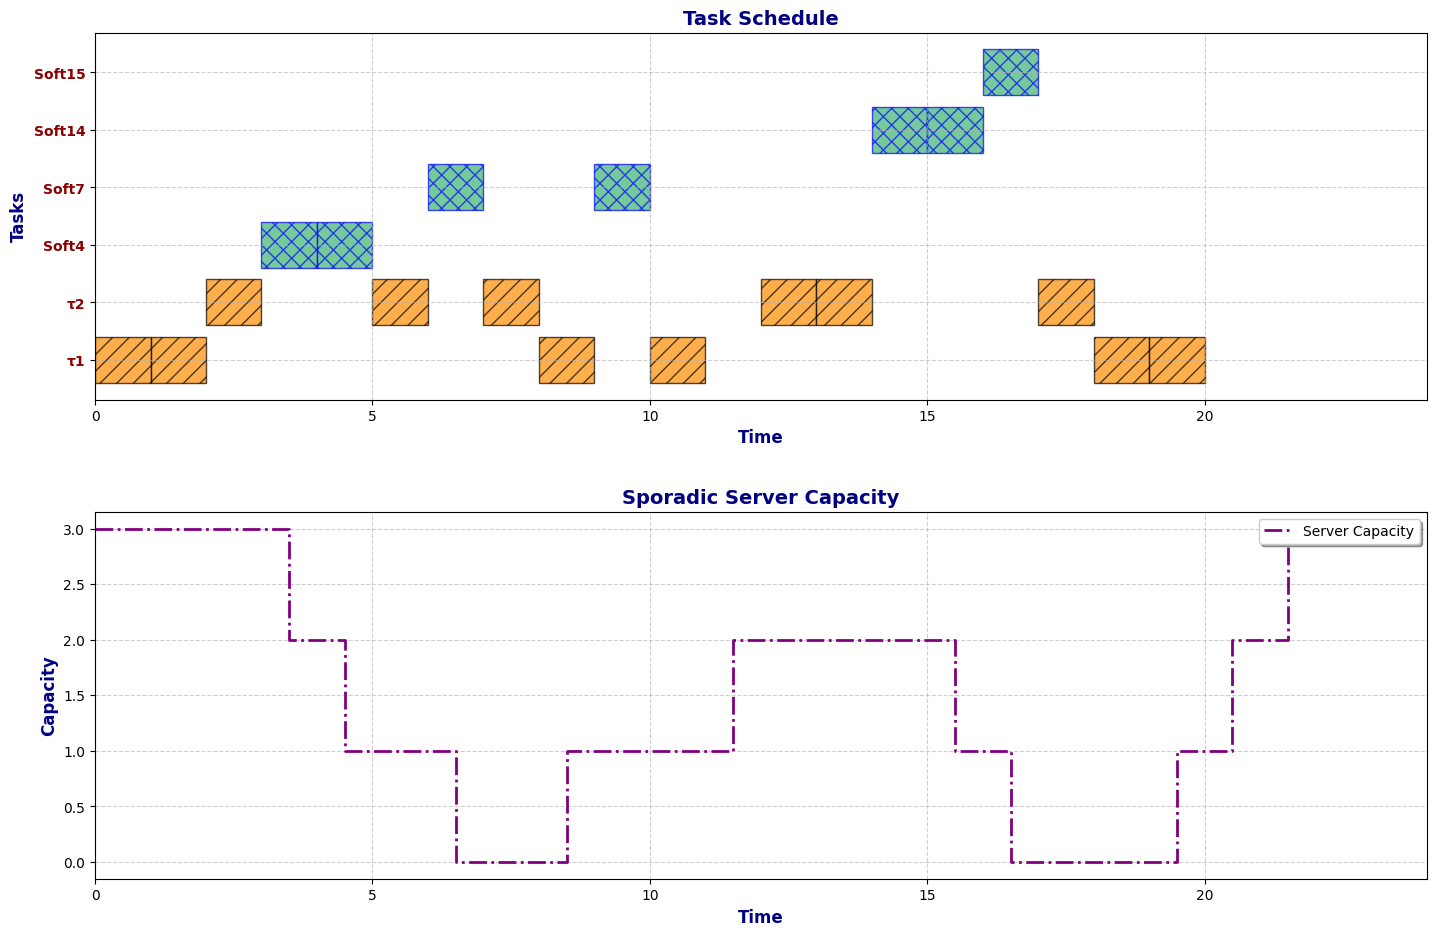

In [13]:
sporadic_server = SporadicServer(server_period=6, server_capacity=3)

task_scheduler = EDFScheduler()
task1 = Task('τ1', 8, 2, 0, 'hard', sporadic_server)
task2 = Task('τ2', 12, 3, 0, 'hard', sporadic_server)
task_scheduler.add_task_to_queue(task1)
task_scheduler.add_task_to_queue(task2)
task_scheduler.periodic_tasks.append(task1)
task_scheduler.periodic_tasks.append(task2)

handle_user_input(sporadic_server)